# Multioutput Regression – Number of target variables greater than the number of features
## Mercury injection capillary pressure experiment
A study project to predict mercury injection capillary pressure (MICP) curve. The data set included a small number of features – well data, geology and lithology – and 200 target variables to be predicted, with a total of 455 data points.

# Detailed description of the assignment
The task is to build a multioutput regression model.

Target variables are ['bv_0', ..., 'bv_100', 'pc_0', ..., 'pc_100']

It is basically 2d data (pc_* - x axis, bv_* - y axis)

1.	Create baseline model of your choice. This should be a simple model (e. g. naive prediction) that can be used to compare the performance of more complex models
2.	Create a multioutput regression model to predict multiple outputs from a given dataset. This could be a linear regression model, a neural network, or any other suitable model
3.	Use appropriate techniques to preprocess the data, such as normalization, feature selection, and feature engineering
4.	Evaluate the performance of the model using appropriate metrics and cross-validation strategy. Use test data to come up with the strategy. Compare it to the baseline
5.	Tune the model's hyperparameters to optimize the model's performance (if needed)
6.	Visualize the results of the model predictions to provide insights into the data
7.	Suggest the improvements to the model. This should include any insights gained from the model and any recommendations for further improvements
8.	Provide a brief summary of the model and the results at the end of the Jupyter notebook (1 paragraph of text in English).

The dataset contains measurements and features related to core samples taken from different wells. The features include:

-	group - identifier of the well from which the core sample was taken 
-	sample - identifier of the core sample; all the data related to a particular well are recorded in one shot 
-	depth - depth at which the core sample was taken 
-	por - measured porosity of the core sample; porosity is the fraction of the volume of pores (empty spaces) to the total volume of the rock 
-	permeability - measured permeability of the core plug sample; permeability is a measure of the ability of a rock to allow fluids to pass through it 
-	den - measured density of the core plug sample; density is the mass per unit volume of the rock 
-	thickness_effective - effective (net) thickness of a formation from which the sample was taken 
-	ntg - net-to-gross ratio of a formation from which the sample was taken; NTG is the ratio of the thickness of reservoir rock to the thickness of the entire interval sampled 
-	x, y - well coordinates 
-	lithology - lithology of core plug sample, determined by a geologist; lithology refers to the physical and chemical characteristics of a rock, such as its mineral composition, texture, and color 
-	gr - measured gamma ray log of the sample depth; gamma ray log measures naturally occurring radioactivity of a formation, which is mainly used for determination of the shaliness of a formation. The values of gamma ray log will be low in clay-free rocks such as sandstones, limestones, dolostones, anhydrites, most salts, and coals, but high in shales because of high concentrations of radioactive material 
-	rhob - measured density log of the sample depth; density log is related to the bulk density of formation. It is used for determination of porosity and lithology differentiation. Measured density values will be closer to the mineralogical (matrix) density in formation with low porosity, and with an increase in porosity, density values will get lower 
-	ct_* - Data related to computer tomographic measurements 

# Domain knowledge
The first step before working with the data was to read some literature on the subject. A MICP experiment is performed by placing a prepared sample in a chamber with mercury. Mercury pressure is gradually increased to a maximum of 60,000 psi, forcing mercury into progressively smaller pores. The resulting curve of volume of mercury forced into the sample vs pressure is used to gain understanding of rock porosity and permeability.

This suggest that the pc_* variables are pressures and bv_* are the volumes of injected mercury. 

In [1]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.multioutput import MultiOutputRegressor
import chime

In [2]:
%load_ext chime

# Model performance metric 
The target variables, bv and pc (i.e mercury volume and pressure) use different scales: pressure scale is 3 orders of magnitude larger. So the variables and their prediction errors are not comparable. Moreover, pressure and volume themselves vary across wide ranges (also a few order of magnitude wide). Therefore, I use mean average percentage error to evaluage model performance. 

# Data preparation
- Group is a sequential well number that does not have physical sense. It is also uniquely defined by well coordinates. So I drop this column.
- Well coordinates as such also do not determine anything but relative well proximity to each other can result in similarities, so I keep them in.
- Same sample numbers across different wells do not result in any similarity so I drop this column as well.
- The only categorical feature (and a very important one) is lithology, so I will one-hot encode it.
- All others will be standardized as usual.

In [3]:
train = pd.read_csv('train.csv'); train

,group,sample,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,...,pc_91,pc_92,pc_93,pc_94,pc_95,pc_96,pc_97,pc_98,pc_99,pc_100
0,3,52,1660.178974,18.556209,2.740942,1971.579998,2396.714551,2799.219912,1951.977330,2041.857394,...,20517.973164,23072.031367,25918.199746,29130.680234,32741.818105,36776.940391,41337.948828,46440.194570,52182.348633,58608.434023
1,4,92,3890.779426,8.555400,2.834776,2513.180531,3001.782975,2348.160682,2414.636280,2798.706138,...,4178.079326,4564.280930,4987.905991,5457.903966,5976.209199,6537.572468,7149.014724,7826.130471,8559.884813,9368.567796
2,3,90,2287.441253,-0.169935,2.761468,2274.773580,1083.899155,2974.647775,2713.863889,2381.094609,...,20522.705605,23075.290605,25927.208926,29136.474492,32743.575156,36780.525273,41344.256875,46461.810508,52207.803164,58651.855859
3,3,49,2144.788740,28.192998,2.637605,1776.270868,2374.721334,2670.367528,2814.751969,2919.311685,...,20522.544570,23075.227422,25928.721426,29137.418496,32742.759414,36779.554531,41344.410508,46463.711484,52212.429531,58661.142344
4,2,65,3754.453151,4.136069,2.900202,1787.771840,1893.016733,2818.411074,1542.522104,2246.952313,...,4223.781546,4615.144614,5045.280631,5520.831567,6044.115860,6611.085441,7231.857753,7913.697529,8657.308785,9475.725759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,5,51,2097.045676,14.781216,2.688458,2455.839335,2480.124636,2574.049871,2511.215039,2395.579990,...,20522.071465,23074.956074,25926.207676,29135.754883,32743.289434,36780.388477,41343.607969,46459.794961,52204.491289,58646.683398
451,5,35,2078.198020,19.385152,2.684518,2044.566279,2052.309283,2343.335254,2529.277934,2360.570479,...,20515.948887,23070.407505,25916.965068,29127.595225,32738.985176,36777.577871,41334.507256,46434.336172,52175.582588,58596.777002
452,2,68,3672.405920,26.585923,2.772035,2040.649000,2573.163502,1292.780567,2079.696767,2355.948265,...,4384.635758,4792.584608,5241.195855,5734.702477,6275.782170,6869.952183,7510.868407,8221.208958,8994.294442,9843.708743
453,5,6,2094.513127,16.977858,2.705836,2591.491630,2295.452470,2432.286576,2406.785838,2705.931007,...,20522.289775,23073.814199,25925.970928,29138.137822,32746.070488,36781.718086,41348.267930,46455.386035,52207.608379,58647.802676


In [4]:
X = train.iloc[:, :20]; X

,group,sample,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,permeability,ntg,thickness_effective,x,y,lithology,gr,rhob
0,3,52,1660.178974,18.556209,2.740942,1971.579998,2396.714551,2799.219912,1951.977330,2041.857394,2442.840273,2318.618853,6.425410,0.106890,5.658985,18985,5423,limestone,37.738168,2.664759
1,4,92,3890.779426,8.555400,2.834776,2513.180531,3001.782975,2348.160682,2414.636280,2798.706138,3035.549168,2729.578887,14.300516,0.718312,4.483886,16790,3644,shale,42.371106,2.760788
2,3,90,2287.441253,-0.169935,2.761468,2274.773580,1083.899155,2974.647775,2713.863889,2381.094609,2085.069195,2747.971468,12.825353,0.639979,6.349391,18985,5423,sandstone,42.931089,2.624635
3,3,49,2144.788740,28.192998,2.637605,1776.270868,2374.721334,2670.367528,2814.751969,2919.311685,2016.024319,2546.626337,13.320168,0.288901,3.819145,18985,5423,limestone,39.485022,2.634539
4,2,65,3754.453151,4.136069,2.900202,1787.771840,1893.016733,2818.411074,1542.522104,2246.952313,1943.089817,1561.393112,7.183351,0.500868,6.593625,16169,5288,siltstome,34.846060,2.459622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,5,51,2097.045676,14.781216,2.688458,2455.839335,2480.124636,2574.049871,2511.215039,2395.579990,2439.147140,2089.051532,41.015660,0.709441,7.313445,19850,3873,limestone,30.240244,2.562103
451,5,35,2078.198020,19.385152,2.684518,2044.566279,2052.309283,2343.335254,2529.277934,2360.570479,2256.546050,2663.343376,1.366440,0.554834,8.669671,19850,3873,limestone,14.771108,2.617332
452,2,68,3672.405920,26.585923,2.772035,2040.649000,2573.163502,1292.780567,2079.696767,2355.948265,2281.831720,2071.560649,3.371203,0.786869,4.971094,16169,5288,sandstone,41.162699,2.687207
453,5,6,2094.513127,16.977858,2.705836,2591.491630,2295.452470,2432.286576,2406.785838,2705.931007,2400.377198,2512.672454,16.081238,0.671111,7.022591,19850,3873,sandstone,37.093964,2.653836


In [5]:
y = train.iloc[:, 20:]; y

,bv_0,bv_1,bv_2,bv_3,bv_4,bv_5,bv_6,bv_7,bv_8,bv_9,...,pc_91,pc_92,pc_93,pc_94,pc_95,pc_96,pc_97,pc_98,pc_99,pc_100
0,8.314193e-30,0.022937,0.175831,0.343738,0.457215,0.544975,0.619610,0.668326,0.714923,0.758957,...,20517.973164,23072.031367,25918.199746,29130.680234,32741.818105,36776.940391,41337.948828,46440.194570,52182.348633,58608.434023
1,8.404712e-30,0.065743,0.110847,0.149221,0.182478,0.207055,0.251148,0.264525,0.286616,0.296471,...,4178.079326,4564.280930,4987.905991,5457.903966,5976.209199,6537.572468,7149.014724,7826.130471,8559.884813,9368.567796
2,9.628115e-30,0.065462,0.126050,0.185575,0.236476,0.276897,0.326915,0.352935,0.379736,0.399494,...,20522.705605,23075.290605,25927.208926,29136.474492,32743.575156,36780.525273,41344.256875,46461.810508,52207.803164,58651.855859
3,1.001518e-29,0.035238,0.135762,0.260780,0.354239,0.437589,0.512409,0.573600,0.627993,0.674529,...,20522.544570,23075.227422,25928.721426,29137.418496,32742.759414,36779.554531,41344.410508,46463.711484,52212.429531,58661.142344
4,1.003009e-29,0.064098,0.117940,0.167830,0.213313,0.245085,0.286452,0.302900,0.324897,0.341102,...,4223.781546,4615.144614,5045.280631,5520.831567,6044.115860,6611.085441,7231.857753,7913.697529,8657.308785,9475.725759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,8.405910e-30,0.011935,0.266474,0.392014,0.488393,0.561142,0.629793,0.674519,0.721665,0.761462,...,20522.071465,23074.956074,25926.207676,29135.754883,32743.289434,36780.388477,41343.607969,46459.794961,52204.491289,58646.683398
451,9.770500e-30,0.035415,0.148900,0.262791,0.349767,0.428302,0.524900,0.561232,0.611864,0.654517,...,20515.948887,23070.407505,25916.965068,29127.595225,32738.985176,36777.577871,41334.507256,46434.336172,52175.582588,58596.777002
452,9.858864e-30,0.035401,0.105316,0.252543,0.343569,0.436199,0.520484,0.579677,0.666790,0.735258,...,4384.635758,4792.584608,5241.195855,5734.702477,6275.782170,6869.952183,7510.868407,8221.208958,8994.294442,9843.708743
453,1.020829e-29,0.035444,0.181987,0.246770,0.296267,0.331121,0.381807,0.402956,0.436622,0.463018,...,20522.289775,23073.814199,25925.970928,29138.137822,32746.070488,36781.718086,41348.267930,46455.386035,52207.608379,58647.802676


In [6]:
class Preprocess():
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        df = X.copy().drop(columns=['group', 'sample'])
        self.numeric_cols = df.select_dtypes(include='number').columns
        self.categoric_cols = df.select_dtypes(include='object').columns

        ct = ColumnTransformer(
            [
                ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist', drop=None), self.categoric_cols),
                ('scale', StandardScaler(), self.numeric_cols)
            ],
            n_jobs=-1
        )
        self.transf = ct.fit(df)
        self.features = ct.get_feature_names_out()
        return self
    
    def transform(self, X, y=None):
        df = X.copy().drop(columns=['group', 'sample'])
        return pd.DataFrame(self.transf.transform(df), columns=self.features)


In [7]:
prep = Preprocess().fit(X)

In [8]:
X_prep = prep.transform(X)

In [9]:
X_prep

,onehot__lithology_clay sandstone,onehot__lithology_limestone,onehot__lithology_sandstone,onehot__lithology_shale,onehot__lithology_siltstome,scale__depth,scale__por,scale__den,scale__ct_1,scale__ct_2,...,scale__ct_5,scale__ct_6,scale__ct_7,scale__permeability,scale__ntg,scale__thickness_effective,scale__x,scale__y,scale__gr,scale__rhob
0,0.0,1.0,0.0,0.0,0.0,-1.497434,0.249045,-0.111626,-1.219575,0.003803,...,-1.089198,0.048238,-0.201495,-0.452414,-1.788082,-0.135881,0.509146,1.483051,0.025396,0.362979
1,0.0,0.0,0.0,1.0,0.0,1.580383,-0.766025,1.035027,0.411760,1.682853,...,1.173064,1.738182,1.012327,0.090066,1.077963,-0.888972,-0.943063,-0.766753,0.518081,1.311781
2,0.0,0.0,1.0,0.0,0.0,-0.631928,-1.651635,0.139207,-0.306337,-3.639227,...,-0.075200,-0.971846,1.066651,-0.011551,0.710776,0.306582,0.509146,1.483051,0.577632,-0.033471
3,0.0,1.0,0.0,0.0,0.0,-0.828762,1.227167,-1.374409,-1.807858,-0.057228,...,1.533560,-1.168708,0.471953,0.022535,-0.934904,-1.314987,0.509146,1.483051,0.211163,0.064386
4,0.0,0.0,0.0,0.0,1.0,1.392278,-1.214581,1.834544,-1.773216,-1.393946,...,-0.476158,-1.376661,-2.438056,-0.400203,0.058696,0.463106,-1.353916,1.312324,-0.282163,-1.663863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.0,1.0,0.0,0.0,0.0,-0.894639,-0.134112,-0.752990,0.239044,0.235264,...,-0.031902,0.037708,-0.879551,1.930351,1.036382,0.924420,1.081429,-0.477149,-0.771965,-0.651311
451,0.0,1.0,0.0,0.0,0.0,-0.920645,0.333181,-0.801132,-0.999735,-0.951913,...,-0.136547,-0.482928,0.816692,-0.800904,0.311661,1.793590,1.081429,-0.477149,-2.417016,-0.105620
452,0.0,0.0,1.0,0.0,0.0,1.279068,1.064050,0.268330,-1.011535,0.493444,...,-0.150363,-0.410833,-0.931212,-0.662805,1.399327,-0.576732,-1.353916,1.312324,0.389574,0.584775
453,0.0,0.0,1.0,0.0,0.0,-0.898133,0.088844,-0.540626,0.647638,-0.277197,...,0.895754,-0.072833,0.371666,0.212732,0.856709,0.738019,1.081429,-0.477149,-0.043112,0.255056


In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_prep, y,
                                                  test_size=45,
                                                  random_state=8,
                                                  shuffle=True)


# Baseline model. Ordinary least squares linear regression

In [46]:
from sklearn.linear_model import LinearRegression

In [12]:
lr = LinearRegression(n_jobs=-1).fit(X_train, y_train)

In [13]:
y_pred = lr.predict(X_val)

Overall score on the validation set

In [14]:
mean_absolute_percentage_error(y_val, y_pred)

0.2753322550022459

Separate MAPE for pressure

In [15]:
mean_absolute_percentage_error(y_val.iloc[0,101:], y_pred[0,101:])

0.04355066843127384

Separate MAPE for volume

In [16]:
mean_absolute_percentage_error(y_val.iloc[0,:101], y_pred[0,:101])

0.18374593876618342

Predicted pressure values must increase consequtively

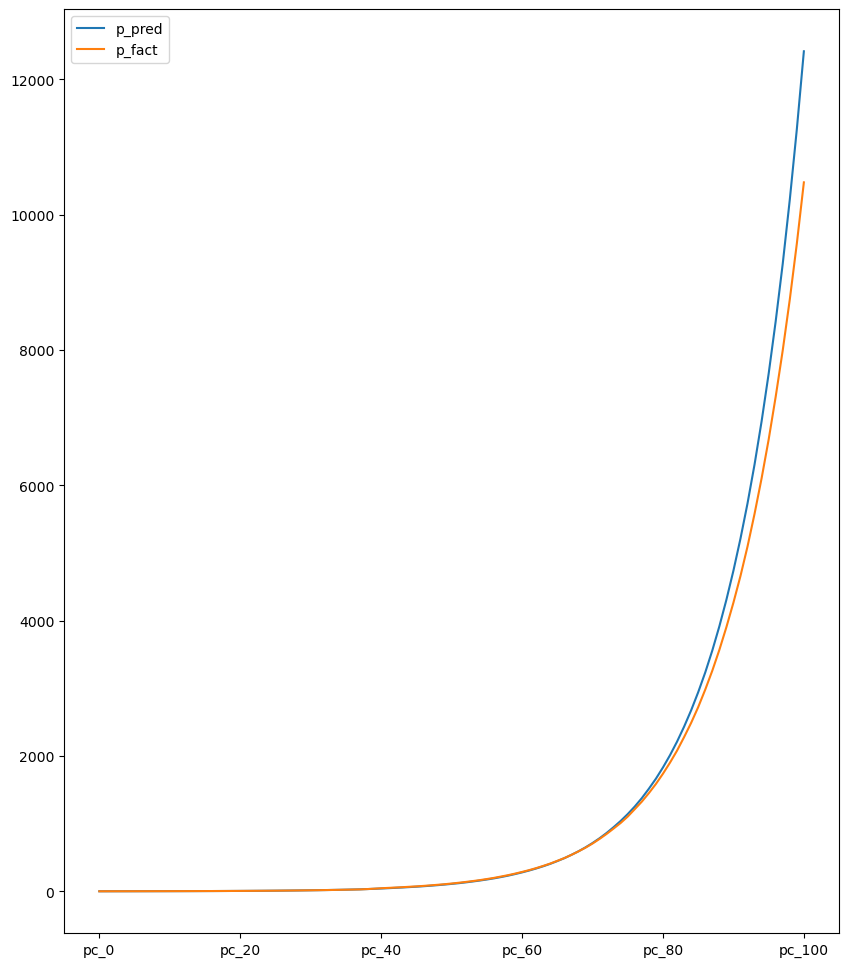

In [17]:
pd.DataFrame({'p_pred':y_pred[0,101:], 'p_fact': y_val.iloc[0,101:]}).plot.line(figsize=(10,12));

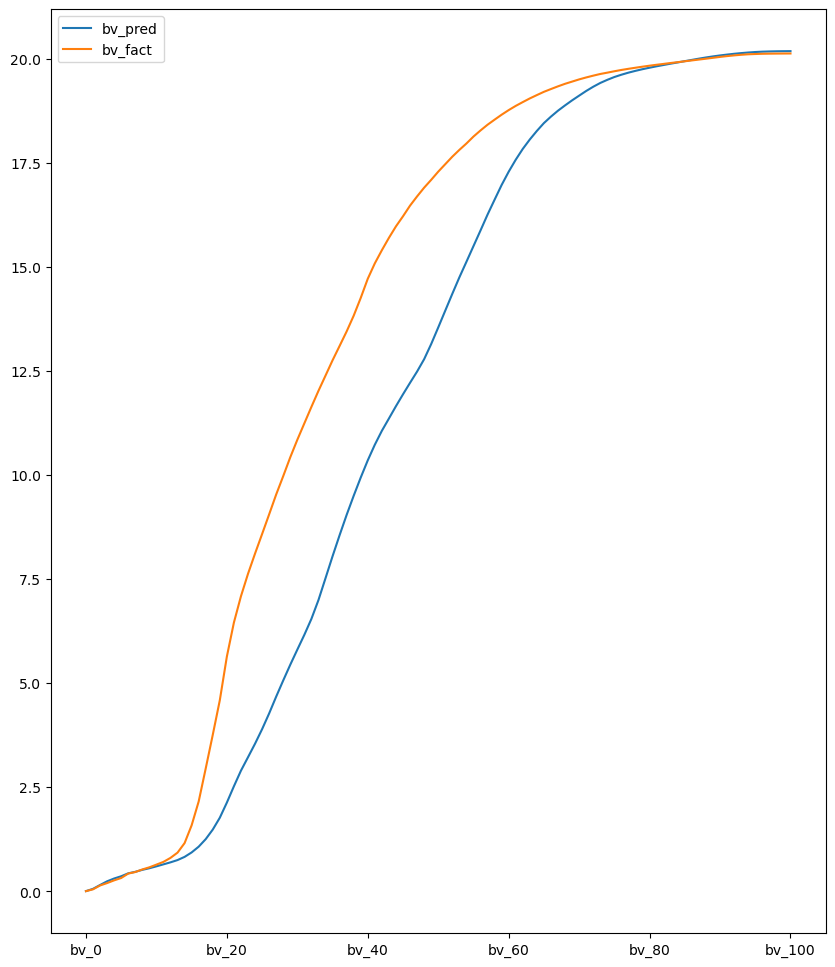

In [18]:
pd.DataFrame({'bv_pred':y_pred[0,:101], 'bv_fact': y_val.iloc[0,:101]}).plot.line(figsize=(10,12));

There is a much better match between pressure curves, likely because pressure has higher importance due to larger scale.

Feature importance:

In [19]:
feature_importance = pd.DataFrame(lr.coef_, columns = X_prep.columns).mean(axis=0).abs().sort_values(ascending=False)
feature_importance

scale__depth                        945.854820
onehot__lithology_clay sandstone    217.770011
onehot__lithology_limestone         155.015609
onehot__lithology_sandstone         112.932298
onehot__lithology_shale             108.730360
onehot__lithology_siltstome          58.552463
scale__den                           21.461825
scale__por                           21.240530
scale__ct_6                          17.902236
scale__ct_3                          16.969501
scale__x                             12.093552
scale__rhob                           9.063697
scale__y                              8.831184
scale__ct_5                           6.987944
scale__gr                             5.553403
scale__thickness_effective            4.958965
scale__ct_7                           4.624324
scale__permeability                   3.114393
scale__ct_4                           2.171651
scale__ct_1                           0.736230
scale__ntg                            0.725809
scale__ct_2  

Most important factors are depth, followed by lithology

# Model optimization

## Balancing the impact of pressure and volume
- Pressure and volume scales are different, so they have different impact on model training.
- EDA has demonstrated that, during MICP experiments, logarithm of pressure was increased by equal increments
- So I will use pressure logarithm under the hood to train models and backtranform to pressure at the prediction stage

In [44]:
class MyEstimator:
    def __init__(self, regressor, **kwargs):
        self.regressor = regressor()
        
    def fit(self, X, y):
        y_p = y.filter(regex='^pc_').apply(np.log)
        y_v = y.filter(regex='^bv_')
        self.n_p = y_p.shape[1] # No. of data points
        y_transform = pd.concat([y_v, y_p], axis=1)
        self.regressor.fit(X, y_transform)
        return self
    
    def predict(self, X, y=None):
        y_pred = self.regressor.predict(X)
        y_p = np.exp(y_pred[:, self.n_p:])
        y_v = y_pred[:, :self.n_p]
        return np.concatenate((y_v, y_p), axis=1)

In [47]:
lr_2 = MyEstimator(LinearRegression).fit(X_train, y_train)

In [48]:
y_pred_2 = lr_2.predict(X_val)

Overall score on the validation set

In [49]:
mean_absolute_percentage_error(y_val, y_pred_2)

0.27524669410965347

Separate MAPE for pressure

In [50]:
mean_absolute_percentage_error(y_val.iloc[0,101:], y_pred_2[0,101:])

0.025526781058132123

Separate MAPE for volume

In [51]:
mean_absolute_percentage_error(y_val.iloc[0,:101], y_pred_2[0,:101])

0.18374593876618342

### Conclusion
Insignificant improvement from balancing

## Linear regression with regularization

In [37]:
from sklearn.linear_model import Ridge

In [38]:
estimator = Ridge(random_state=8)

In [39]:
params = {
    'alpha': [1e-6, 1e-5, 0.0001, 0.001, 0.01, 0.1, 1],
}

In [40]:
model = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    cv=10,
    verbose=3)

In [41]:
%%time
%%chime
model.fit(X_train, y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
CPU times: user 80.4 ms, sys: 9.18 ms, total: 89.6 ms
Wall time: 267 ms


In [42]:
model.best_params_

{'alpha': 1e-06}

In [43]:
model.best_score_

-0.28909876038371274

In [44]:
y_pred = model.predict(X_val)

Overall score on the validation set

In [45]:
mean_absolute_percentage_error(y_val, y_pred)

0.2753322556991612

Separate MAPE for pressure

In [46]:
mean_absolute_percentage_error(y_val.iloc[0,101:], y_pred[0,101:])

0.043550670068249905

Separate MAPE for volume

In [47]:
mean_absolute_percentage_error(y_val.iloc[0,:101], y_pred[0,:101])

0.18374593806796286

No improvement compared to ordinary linear regression.

# KNN

In [11]:
from sklearn.neighbors import KNeighborsRegressor

In [12]:
estimator = KNeighborsRegressor(metric='minkowski', n_jobs=-1)

In [13]:
params = {
    'n_neighbors': list(range(2,25)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

In [14]:
model = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring='neg_mean_absolute_percentage_error',
    cv=10,
    verbose=3)

In [15]:
%%time
%%chime
model.fit(X_train, y_train)

Fitting 10 folds for each of 138 candidates, totalling 1380 fits
[CV 1/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.311 total time=   0.1s
[CV 2/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.402 total time=   0.0s
[CV 3/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.345 total time=   0.0s
[CV 4/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.311 total time=   0.0s
[CV 5/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.207 total time=   0.0s
[CV 6/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.471 total time=   0.0s
[CV 7/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.226 total time=   0.0s
[CV 8/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.445 total time=   0.0s
[CV 9/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.252 total time=   0.0s
[CV 10/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.271 total time=   0.0s
[CV 1/10] END n_neighbors=2, p=1, weights=distance;, score=-0.310 total time=   0.0s
[CV 2/10]

[CV 4/10] END n_neighbors=3, p=3, weights=uniform;, score=-0.316 total time=   0.0s
[CV 5/10] END n_neighbors=3, p=3, weights=uniform;, score=-0.225 total time=   0.0s
[CV 6/10] END n_neighbors=3, p=3, weights=uniform;, score=-0.477 total time=   0.0s
[CV 7/10] END n_neighbors=3, p=3, weights=uniform;, score=-0.234 total time=   0.0s
[CV 8/10] END n_neighbors=3, p=3, weights=uniform;, score=-0.493 total time=   0.0s
[CV 9/10] END n_neighbors=3, p=3, weights=uniform;, score=-0.249 total time=   0.0s
[CV 10/10] END n_neighbors=3, p=3, weights=uniform;, score=-0.291 total time=   0.0s
[CV 1/10] END n_neighbors=3, p=3, weights=distance;, score=-0.333 total time=   0.0s
[CV 2/10] END n_neighbors=3, p=3, weights=distance;, score=-0.362 total time=   0.0s
[CV 3/10] END n_neighbors=3, p=3, weights=distance;, score=-0.354 total time=   0.0s
[CV 4/10] END n_neighbors=3, p=3, weights=distance;, score=-0.317 total time=   0.0s
[CV 5/10] END n_neighbors=3, p=3, weights=distance;, score=-0.222 total

[CV 2/10] END n_neighbors=5, p=2, weights=uniform;, score=-0.404 total time=   0.0s
[CV 3/10] END n_neighbors=5, p=2, weights=uniform;, score=-0.391 total time=   0.0s
[CV 4/10] END n_neighbors=5, p=2, weights=uniform;, score=-0.349 total time=   0.0s
[CV 5/10] END n_neighbors=5, p=2, weights=uniform;, score=-0.212 total time=   0.0s
[CV 6/10] END n_neighbors=5, p=2, weights=uniform;, score=-0.468 total time=   0.0s
[CV 7/10] END n_neighbors=5, p=2, weights=uniform;, score=-0.217 total time=   0.0s
[CV 8/10] END n_neighbors=5, p=2, weights=uniform;, score=-0.442 total time=   0.0s
[CV 9/10] END n_neighbors=5, p=2, weights=uniform;, score=-0.292 total time=   0.0s
[CV 10/10] END n_neighbors=5, p=2, weights=uniform;, score=-0.306 total time=   0.0s
[CV 1/10] END n_neighbors=5, p=2, weights=distance;, score=-0.317 total time=   0.0s
[CV 2/10] END n_neighbors=5, p=2, weights=distance;, score=-0.402 total time=   0.0s
[CV 3/10] END n_neighbors=5, p=2, weights=distance;, score=-0.385 total t

[CV 9/10] END n_neighbors=6, p=3, weights=distance;, score=-0.286 total time=   0.0s
[CV 10/10] END n_neighbors=6, p=3, weights=distance;, score=-0.328 total time=   0.0s
[CV 1/10] END n_neighbors=7, p=1, weights=uniform;, score=-0.308 total time=   0.0s
[CV 2/10] END n_neighbors=7, p=1, weights=uniform;, score=-0.369 total time=   0.0s
[CV 3/10] END n_neighbors=7, p=1, weights=uniform;, score=-0.322 total time=   0.0s
[CV 4/10] END n_neighbors=7, p=1, weights=uniform;, score=-0.351 total time=   0.0s
[CV 5/10] END n_neighbors=7, p=1, weights=uniform;, score=-0.203 total time=   0.0s
[CV 6/10] END n_neighbors=7, p=1, weights=uniform;, score=-0.454 total time=   0.0s
[CV 7/10] END n_neighbors=7, p=1, weights=uniform;, score=-0.246 total time=   0.0s
[CV 8/10] END n_neighbors=7, p=1, weights=uniform;, score=-0.423 total time=   0.0s
[CV 9/10] END n_neighbors=7, p=1, weights=uniform;, score=-0.281 total time=   0.0s
[CV 10/10] END n_neighbors=7, p=1, weights=uniform;, score=-0.333 total t

[CV 7/10] END n_neighbors=8, p=3, weights=uniform;, score=-0.233 total time=   0.0s
[CV 8/10] END n_neighbors=8, p=3, weights=uniform;, score=-0.477 total time=   0.0s
[CV 9/10] END n_neighbors=8, p=3, weights=uniform;, score=-0.309 total time=   0.0s
[CV 10/10] END n_neighbors=8, p=3, weights=uniform;, score=-0.338 total time=   0.0s
[CV 1/10] END n_neighbors=8, p=3, weights=distance;, score=-0.354 total time=   0.0s
[CV 2/10] END n_neighbors=8, p=3, weights=distance;, score=-0.408 total time=   0.0s
[CV 3/10] END n_neighbors=8, p=3, weights=distance;, score=-0.393 total time=   0.0s
[CV 4/10] END n_neighbors=8, p=3, weights=distance;, score=-0.371 total time=   0.0s
[CV 5/10] END n_neighbors=8, p=3, weights=distance;, score=-0.241 total time=   0.0s
[CV 6/10] END n_neighbors=8, p=3, weights=distance;, score=-0.494 total time=   0.0s
[CV 7/10] END n_neighbors=8, p=3, weights=distance;, score=-0.230 total time=   0.0s
[CV 8/10] END n_neighbors=8, p=3, weights=distance;, score=-0.474 to

[CV 3/10] END n_neighbors=10, p=2, weights=distance;, score=-0.380 total time=   0.0s
[CV 4/10] END n_neighbors=10, p=2, weights=distance;, score=-0.363 total time=   0.0s
[CV 5/10] END n_neighbors=10, p=2, weights=distance;, score=-0.213 total time=   0.0s
[CV 6/10] END n_neighbors=10, p=2, weights=distance;, score=-0.476 total time=   0.0s
[CV 7/10] END n_neighbors=10, p=2, weights=distance;, score=-0.229 total time=   0.0s
[CV 8/10] END n_neighbors=10, p=2, weights=distance;, score=-0.486 total time=   0.0s
[CV 9/10] END n_neighbors=10, p=2, weights=distance;, score=-0.314 total time=   0.0s
[CV 10/10] END n_neighbors=10, p=2, weights=distance;, score=-0.331 total time=   0.0s
[CV 1/10] END n_neighbors=10, p=3, weights=uniform;, score=-0.348 total time=   0.0s
[CV 2/10] END n_neighbors=10, p=3, weights=uniform;, score=-0.412 total time=   0.0s
[CV 3/10] END n_neighbors=10, p=3, weights=uniform;, score=-0.415 total time=   0.0s
[CV 4/10] END n_neighbors=10, p=3, weights=uniform;, sco

[CV 1/10] END n_neighbors=12, p=1, weights=distance;, score=-0.304 total time=   0.0s
[CV 2/10] END n_neighbors=12, p=1, weights=distance;, score=-0.360 total time=   0.0s
[CV 3/10] END n_neighbors=12, p=1, weights=distance;, score=-0.350 total time=   0.0s
[CV 4/10] END n_neighbors=12, p=1, weights=distance;, score=-0.380 total time=   0.0s
[CV 5/10] END n_neighbors=12, p=1, weights=distance;, score=-0.221 total time=   0.0s
[CV 6/10] END n_neighbors=12, p=1, weights=distance;, score=-0.440 total time=   0.0s
[CV 7/10] END n_neighbors=12, p=1, weights=distance;, score=-0.232 total time=   0.0s
[CV 8/10] END n_neighbors=12, p=1, weights=distance;, score=-0.456 total time=   0.0s
[CV 9/10] END n_neighbors=12, p=1, weights=distance;, score=-0.284 total time=   0.0s
[CV 10/10] END n_neighbors=12, p=1, weights=distance;, score=-0.354 total time=   0.0s
[CV 1/10] END n_neighbors=12, p=2, weights=uniform;, score=-0.362 total time=   0.0s
[CV 2/10] END n_neighbors=12, p=2, weights=uniform;, s

[CV 4/10] END n_neighbors=13, p=3, weights=distance;, score=-0.406 total time=   0.0s
[CV 5/10] END n_neighbors=13, p=3, weights=distance;, score=-0.240 total time=   0.0s
[CV 6/10] END n_neighbors=13, p=3, weights=distance;, score=-0.521 total time=   0.0s
[CV 7/10] END n_neighbors=13, p=3, weights=distance;, score=-0.249 total time=   0.0s
[CV 8/10] END n_neighbors=13, p=3, weights=distance;, score=-0.526 total time=   0.0s
[CV 9/10] END n_neighbors=13, p=3, weights=distance;, score=-0.351 total time=   0.0s
[CV 10/10] END n_neighbors=13, p=3, weights=distance;, score=-0.364 total time=   0.0s
[CV 1/10] END n_neighbors=14, p=1, weights=uniform;, score=-0.310 total time=   0.0s
[CV 2/10] END n_neighbors=14, p=1, weights=uniform;, score=-0.368 total time=   0.0s
[CV 3/10] END n_neighbors=14, p=1, weights=uniform;, score=-0.359 total time=   0.0s
[CV 4/10] END n_neighbors=14, p=1, weights=uniform;, score=-0.384 total time=   0.0s
[CV 5/10] END n_neighbors=14, p=1, weights=uniform;, scor

[CV 4/10] END n_neighbors=15, p=2, weights=distance;, score=-0.403 total time=   0.0s
[CV 5/10] END n_neighbors=15, p=2, weights=distance;, score=-0.225 total time=   0.0s
[CV 6/10] END n_neighbors=15, p=2, weights=distance;, score=-0.484 total time=   0.0s
[CV 7/10] END n_neighbors=15, p=2, weights=distance;, score=-0.245 total time=   0.0s
[CV 8/10] END n_neighbors=15, p=2, weights=distance;, score=-0.518 total time=   0.0s
[CV 9/10] END n_neighbors=15, p=2, weights=distance;, score=-0.339 total time=   0.0s
[CV 10/10] END n_neighbors=15, p=2, weights=distance;, score=-0.354 total time=   0.0s
[CV 1/10] END n_neighbors=15, p=3, weights=uniform;, score=-0.380 total time=   0.0s
[CV 2/10] END n_neighbors=15, p=3, weights=uniform;, score=-0.435 total time=   0.0s
[CV 3/10] END n_neighbors=15, p=3, weights=uniform;, score=-0.447 total time=   0.0s
[CV 4/10] END n_neighbors=15, p=3, weights=uniform;, score=-0.432 total time=   0.0s
[CV 5/10] END n_neighbors=15, p=3, weights=uniform;, scor

[CV 4/10] END n_neighbors=17, p=2, weights=uniform;, score=-0.423 total time=   0.0s
[CV 5/10] END n_neighbors=17, p=2, weights=uniform;, score=-0.241 total time=   0.0s
[CV 6/10] END n_neighbors=17, p=2, weights=uniform;, score=-0.489 total time=   0.0s
[CV 7/10] END n_neighbors=17, p=2, weights=uniform;, score=-0.263 total time=   0.0s
[CV 8/10] END n_neighbors=17, p=2, weights=uniform;, score=-0.540 total time=   0.0s
[CV 9/10] END n_neighbors=17, p=2, weights=uniform;, score=-0.355 total time=   0.0s
[CV 10/10] END n_neighbors=17, p=2, weights=uniform;, score=-0.368 total time=   0.0s
[CV 1/10] END n_neighbors=17, p=2, weights=distance;, score=-0.352 total time=   0.0s
[CV 2/10] END n_neighbors=17, p=2, weights=distance;, score=-0.419 total time=   0.0s
[CV 3/10] END n_neighbors=17, p=2, weights=distance;, score=-0.444 total time=   0.0s
[CV 4/10] END n_neighbors=17, p=2, weights=distance;, score=-0.416 total time=   0.0s
[CV 5/10] END n_neighbors=17, p=2, weights=distance;, score=

[CV 5/10] END n_neighbors=19, p=1, weights=distance;, score=-0.225 total time=   0.0s
[CV 6/10] END n_neighbors=19, p=1, weights=distance;, score=-0.444 total time=   0.0s
[CV 7/10] END n_neighbors=19, p=1, weights=distance;, score=-0.255 total time=   0.0s
[CV 8/10] END n_neighbors=19, p=1, weights=distance;, score=-0.475 total time=   0.0s
[CV 9/10] END n_neighbors=19, p=1, weights=distance;, score=-0.310 total time=   0.0s
[CV 10/10] END n_neighbors=19, p=1, weights=distance;, score=-0.354 total time=   0.0s
[CV 1/10] END n_neighbors=19, p=2, weights=uniform;, score=-0.351 total time=   0.0s
[CV 2/10] END n_neighbors=19, p=2, weights=uniform;, score=-0.433 total time=   0.0s
[CV 3/10] END n_neighbors=19, p=2, weights=uniform;, score=-0.461 total time=   0.0s
[CV 4/10] END n_neighbors=19, p=2, weights=uniform;, score=-0.449 total time=   0.0s
[CV 5/10] END n_neighbors=19, p=2, weights=uniform;, score=-0.246 total time=   0.0s
[CV 6/10] END n_neighbors=19, p=2, weights=uniform;, score

[CV 1/10] END n_neighbors=20, p=3, weights=distance;, score=-0.377 total time=   0.0s
[CV 2/10] END n_neighbors=20, p=3, weights=distance;, score=-0.450 total time=   0.0s
[CV 3/10] END n_neighbors=20, p=3, weights=distance;, score=-0.473 total time=   0.0s
[CV 4/10] END n_neighbors=20, p=3, weights=distance;, score=-0.460 total time=   0.0s
[CV 5/10] END n_neighbors=20, p=3, weights=distance;, score=-0.268 total time=   0.0s
[CV 6/10] END n_neighbors=20, p=3, weights=distance;, score=-0.525 total time=   0.0s
[CV 7/10] END n_neighbors=20, p=3, weights=distance;, score=-0.285 total time=   0.0s
[CV 8/10] END n_neighbors=20, p=3, weights=distance;, score=-0.585 total time=   0.0s
[CV 9/10] END n_neighbors=20, p=3, weights=distance;, score=-0.416 total time=   0.0s
[CV 10/10] END n_neighbors=20, p=3, weights=distance;, score=-0.385 total time=   0.0s
[CV 1/10] END n_neighbors=21, p=1, weights=uniform;, score=-0.335 total time=   0.0s
[CV 2/10] END n_neighbors=21, p=1, weights=uniform;, s

[CV 1/10] END n_neighbors=22, p=2, weights=distance;, score=-0.356 total time=   0.0s
[CV 2/10] END n_neighbors=22, p=2, weights=distance;, score=-0.441 total time=   0.0s
[CV 3/10] END n_neighbors=22, p=2, weights=distance;, score=-0.463 total time=   0.0s
[CV 4/10] END n_neighbors=22, p=2, weights=distance;, score=-0.458 total time=   0.0s
[CV 5/10] END n_neighbors=22, p=2, weights=distance;, score=-0.239 total time=   0.0s
[CV 6/10] END n_neighbors=22, p=2, weights=distance;, score=-0.485 total time=   0.0s
[CV 7/10] END n_neighbors=22, p=2, weights=distance;, score=-0.272 total time=   0.0s
[CV 8/10] END n_neighbors=22, p=2, weights=distance;, score=-0.555 total time=   0.0s
[CV 9/10] END n_neighbors=22, p=2, weights=distance;, score=-0.385 total time=   0.0s
[CV 10/10] END n_neighbors=22, p=2, weights=distance;, score=-0.364 total time=   0.0s
[CV 1/10] END n_neighbors=22, p=3, weights=uniform;, score=-0.385 total time=   0.0s
[CV 2/10] END n_neighbors=22, p=3, weights=uniform;, s

[CV 8/10] END n_neighbors=24, p=1, weights=uniform;, score=-0.495 total time=   0.0s
[CV 9/10] END n_neighbors=24, p=1, weights=uniform;, score=-0.360 total time=   0.0s
[CV 10/10] END n_neighbors=24, p=1, weights=uniform;, score=-0.378 total time=   0.0s
[CV 1/10] END n_neighbors=24, p=1, weights=distance;, score=-0.339 total time=   0.0s
[CV 2/10] END n_neighbors=24, p=1, weights=distance;, score=-0.415 total time=   0.0s
[CV 3/10] END n_neighbors=24, p=1, weights=distance;, score=-0.400 total time=   0.0s
[CV 4/10] END n_neighbors=24, p=1, weights=distance;, score=-0.422 total time=   0.0s
[CV 5/10] END n_neighbors=24, p=1, weights=distance;, score=-0.222 total time=   0.0s
[CV 6/10] END n_neighbors=24, p=1, weights=distance;, score=-0.452 total time=   0.0s
[CV 7/10] END n_neighbors=24, p=1, weights=distance;, score=-0.276 total time=   0.0s
[CV 8/10] END n_neighbors=24, p=1, weights=distance;, score=-0.489 total time=   0.0s
[CV 9/10] END n_neighbors=24, p=1, weights=distance;, sc

In [16]:
model.best_params_

{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}

In [17]:
model.best_score_

-0.3143369862161681

In [18]:
y_pred = model.predict(X_val)

Overall score on the validation set

In [19]:
mean_absolute_percentage_error(y_val, y_pred)

0.23399275833373764

Separate MAPE for pressure

In [20]:
mean_absolute_percentage_error(y_val.iloc[0,101:], y_pred[0,101:])

0.04661204070414009

Separate MAPE for volume

In [21]:
mean_absolute_percentage_error(y_val.iloc[0,:101], y_pred[0,:101])

0.14788453878312321

Some improvement over linear regression (23.4% vs 27.5%)

# Random forest

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
estimator = RandomForestRegressor(n_jobs=-1, random_state=8)

params = {
    'n_estimators': [10, 25, 50, 75, 100, 200],
    'max_depth': [10, 50, 100, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 1.0],
    'bootstrap': [True, False],
    'max_samples': [0.5, 1.0]
}

In [33]:
params = {
    'n_estimators': [150, 200, 250, 300, 400, 500],
    'max_depth': [20, 30, 40, 50, 70, 80, 90],
    'min_samples_split': [2],
    'max_features': [1.0],
    'bootstrap': [True, False],
    'max_samples': [1.0]
}

In [34]:
model = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring='neg_mean_absolute_percentage_error',
    cv=10,
    verbose=3)

In [35]:
%%time
%%chime
model.fit(X_train, y_train)

Fitting 10 folds for each of 84 candidates, totalling 840 fits
[CV 1/10] END bootstrap=True, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=150;, score=-0.251 total time=   1.7s
[CV 2/10] END bootstrap=True, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=150;, score=-0.321 total time=   0.8s
[CV 3/10] END bootstrap=True, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=150;, score=-0.234 total time=   0.8s
[CV 4/10] END bootstrap=True, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=150;, score=-0.184 total time=   0.8s
[CV 5/10] END bootstrap=True, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=150;, score=-0.181 total time=   0.9s
[CV 6/10] END bootstrap=True, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=150;, score=-0.330 total time=   0.8s
[CV 7/10] END bootstrap=True, m

[CV 5/10] END bootstrap=True, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=-0.181 total time=   2.7s
[CV 6/10] END bootstrap=True, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=-0.337 total time=   2.7s
[CV 7/10] END bootstrap=True, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=-0.153 total time=   2.8s
[CV 8/10] END bootstrap=True, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=-0.299 total time=   2.7s
[CV 9/10] END bootstrap=True, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=-0.211 total time=   2.7s
[CV 10/10] END bootstrap=True, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=-0.318 total time=   2.7s
[CV 1/10] END bootstrap=True, max_depth=30, max_features=1.0, max_samples=1.0, min_samples_sp

[CV 10/10] END bootstrap=True, max_depth=30, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=-0.318 total time=   2.2s
[CV 1/10] END bootstrap=True, max_depth=30, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=-0.256 total time=   2.7s
[CV 2/10] END bootstrap=True, max_depth=30, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=-0.316 total time=   2.7s
[CV 3/10] END bootstrap=True, max_depth=30, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=-0.231 total time=   2.7s
[CV 4/10] END bootstrap=True, max_depth=30, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=-0.184 total time=   2.7s
[CV 5/10] END bootstrap=True, max_depth=30, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=-0.181 total time=   2.8s
[CV 6/10] END bootstrap=True, max_depth=30, max_features=1.0, max_samples=1.0, min_samples_sp

[CV 5/10] END bootstrap=True, max_depth=40, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=-0.181 total time=   2.2s
[CV 6/10] END bootstrap=True, max_depth=40, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=-0.339 total time=   2.2s
[CV 7/10] END bootstrap=True, max_depth=40, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=-0.153 total time=   2.2s
[CV 8/10] END bootstrap=True, max_depth=40, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=-0.301 total time=   2.2s
[CV 9/10] END bootstrap=True, max_depth=40, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=-0.212 total time=   2.2s
[CV 10/10] END bootstrap=True, max_depth=40, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=-0.318 total time=   2.2s
[CV 1/10] END bootstrap=True, max_depth=40, max_features=1.0, max_samples=1.0, min_samples_sp

[CV 10/10] END bootstrap=True, max_depth=50, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=300;, score=-0.326 total time=   1.6s
[CV 1/10] END bootstrap=True, max_depth=50, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=-0.256 total time=   2.2s
[CV 2/10] END bootstrap=True, max_depth=50, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=-0.317 total time=   2.2s
[CV 3/10] END bootstrap=True, max_depth=50, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=-0.231 total time=   2.2s
[CV 4/10] END bootstrap=True, max_depth=50, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=-0.184 total time=   2.2s
[CV 5/10] END bootstrap=True, max_depth=50, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=-0.181 total time=   2.2s
[CV 6/10] END bootstrap=True, max_depth=50, max_features=1.0, max_samples=1.0, min_samples_sp

[CV 5/10] END bootstrap=True, max_depth=70, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=300;, score=-0.181 total time=   1.7s
[CV 6/10] END bootstrap=True, max_depth=70, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=300;, score=-0.334 total time=   1.6s
[CV 7/10] END bootstrap=True, max_depth=70, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=300;, score=-0.154 total time=   1.7s
[CV 8/10] END bootstrap=True, max_depth=70, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=300;, score=-0.301 total time=   1.7s
[CV 9/10] END bootstrap=True, max_depth=70, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=300;, score=-0.211 total time=   1.7s
[CV 10/10] END bootstrap=True, max_depth=70, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=300;, score=-0.326 total time=   1.6s
[CV 1/10] END bootstrap=True, max_depth=70, max_features=1.0, max_samples=1.0, min_samples_sp

[CV 10/10] END bootstrap=True, max_depth=80, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=250;, score=-0.325 total time=   1.4s
[CV 1/10] END bootstrap=True, max_depth=80, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=300;, score=-0.256 total time=   1.7s
[CV 2/10] END bootstrap=True, max_depth=80, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=300;, score=-0.319 total time=   1.7s
[CV 3/10] END bootstrap=True, max_depth=80, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=300;, score=-0.233 total time=   1.7s
[CV 4/10] END bootstrap=True, max_depth=80, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=300;, score=-0.184 total time=   1.6s
[CV 5/10] END bootstrap=True, max_depth=80, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=300;, score=-0.181 total time=   1.7s
[CV 6/10] END bootstrap=True, max_depth=80, max_features=1.0, max_samples=1.0, min_samples_sp

[CV 5/10] END bootstrap=True, max_depth=90, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=250;, score=-0.180 total time=   1.4s
[CV 6/10] END bootstrap=True, max_depth=90, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=250;, score=-0.329 total time=   1.4s
[CV 7/10] END bootstrap=True, max_depth=90, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=250;, score=-0.153 total time=   1.4s
[CV 8/10] END bootstrap=True, max_depth=90, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=250;, score=-0.298 total time=   1.4s
[CV 9/10] END bootstrap=True, max_depth=90, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=250;, score=-0.211 total time=   1.4s
[CV 10/10] END bootstrap=True, max_depth=90, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=250;, score=-0.325 total time=   1.4s
[CV 1/10] END bootstrap=True, max_depth=90, max_features=1.0, max_samples=1.0, min_samples_sp

[CV 6/10] END bootstrap=False, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=nan total time=   0.0s
[CV 7/10] END bootstrap=False, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=nan total time=   0.0s
[CV 8/10] END bootstrap=False, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=nan total time=   0.0s
[CV 9/10] END bootstrap=False, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=nan total time=   0.0s
[CV 10/10] END bootstrap=False, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=400;, score=nan total time=   0.0s
[CV 1/10] END bootstrap=False, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=nan total time=   0.0s
[CV 2/10] END bootstrap=False, max_depth=20, max_features=1.0, max_samples=1.0, min_samples_split=2, n_es

[CV 8/10] END bootstrap=False, max_depth=40, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 9/10] END bootstrap=False, max_depth=40, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 10/10] END bootstrap=False, max_depth=40, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 1/10] END bootstrap=False, max_depth=40, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=250;, score=nan total time=   0.0s
[CV 2/10] END bootstrap=False, max_depth=40, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=250;, score=nan total time=   0.0s
[CV 3/10] END bootstrap=False, max_depth=40, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=250;, score=nan total time=   0.0s
[CV 4/10] END bootstrap=False, max_depth=40, max_features=1.0, max_samples=1.0, min_samples_split=2, n_es

[CV 2/10] END bootstrap=False, max_depth=50, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=nan total time=   0.0s
[CV 3/10] END bootstrap=False, max_depth=50, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=nan total time=   0.0s
[CV 4/10] END bootstrap=False, max_depth=50, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=nan total time=   0.0s
[CV 5/10] END bootstrap=False, max_depth=50, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=nan total time=   0.0s
[CV 6/10] END bootstrap=False, max_depth=50, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=nan total time=   0.0s
[CV 7/10] END bootstrap=False, max_depth=50, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=nan total time=   0.0s
[CV 8/10] END bootstrap=False, max_depth=50, max_features=1.0, max_samples=1.0, min_samples_split=2, n_est

[CV 6/10] END bootstrap=False, max_depth=80, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=250;, score=nan total time=   0.0s
[CV 7/10] END bootstrap=False, max_depth=80, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=250;, score=nan total time=   0.0s
[CV 8/10] END bootstrap=False, max_depth=80, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=250;, score=nan total time=   0.0s
[CV 9/10] END bootstrap=False, max_depth=80, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=250;, score=nan total time=   0.0s
[CV 10/10] END bootstrap=False, max_depth=80, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=250;, score=nan total time=   0.0s
[CV 1/10] END bootstrap=False, max_depth=80, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=300;, score=nan total time=   0.0s
[CV 2/10] END bootstrap=False, max_depth=80, max_features=1.0, max_samples=1.0, min_samples_split=2, n_es

[CV 10/10] END bootstrap=False, max_depth=90, max_features=1.0, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=nan total time=   0.0s


/home/denis/MyCode/NonGit/Tests/Aramco/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
420 fits failed out of a total of 840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
420 fits failed with the following error:
Traceback (most recent call last):
  File "/home/denis/MyCode/NonGit/Tests/Aramco/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/denis/MyCode/NonGit/Tests/Aramco/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 397, in fit
    raise ValueError(
ValueError: `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or se

CPU times: user 3min 57s, sys: 33.2 s, total: 4min 30s
Wall time: 11min 40s


In [36]:
model.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_split': 2,
 'n_estimators': 150}

In [37]:
model.best_score_

-0.24800580090717114

In [38]:
y_pred = model.predict(X_val)

Overall score on the validation set

In [39]:
mean_absolute_percentage_error(y_val, y_pred)

0.17872124574054285

Separate MAPE for pressure

In [40]:
mean_absolute_percentage_error(y_val.iloc[0,101:], y_pred[0,101:])

0.04218764063031837

Separate MAPE for volume

In [41]:
mean_absolute_percentage_error(y_val.iloc[0,:101], y_pred[0,:101])

0.20981692807275476

Significant overall improvement over linear regression (17.9% vs 27.5% on the validation set), although volume prediction error is slightly worse.

## AdaBoost
AdaBoost does not support multi-output regression so I use MultiOutputRegressor.

In [11]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor

In [79]:
base_estimator = AdaBoostRegressor(loss='linear', random_state=8)

In [80]:
estimator = MultiOutputRegressor(estimator=base_estimator, n_jobs=-1)

In [97]:
params = {
    'estimator__n_estimators': [70, 100, 150],
    'estimator__learning_rate': [0.01, 0.1, 0.5],
    'estimator__estimator': [DecisionTreeRegressor(random_state=8, max_depth=100),
                         DecisionTreeRegressor(random_state=8, max_depth=None)]
}

In [98]:
model = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring='neg_mean_absolute_percentage_error',
    cv=10,
    verbose=3
)

In [99]:
%%time
%%chime
model.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10] END estimator__estimator=DecisionTreeRegressor(max_depth=100, random_state=8), estimator__learning_rate=0.01, estimator__n_estimators=70;, score=-0.127 total time=  19.9s
[CV 2/10] END estimator__estimator=DecisionTreeRegressor(max_depth=100, random_state=8), estimator__learning_rate=0.01, estimator__n_estimators=70;, score=-0.190 total time=  19.4s
[CV 3/10] END estimator__estimator=DecisionTreeRegressor(max_depth=100, random_state=8), estimator__learning_rate=0.01, estimator__n_estimators=70;, score=-0.204 total time=  19.2s
[CV 4/10] END estimator__estimator=DecisionTreeRegressor(max_depth=100, random_state=8), estimator__learning_rate=0.01, estimator__n_estimators=70;, score=-0.152 total time=  19.4s
[CV 5/10] END estimator__estimator=DecisionTreeRegressor(max_depth=100, random_state=8), estimator__learning_rate=0.01, estimator__n_estimators=70;, score=-0.145 total time=  19.4s
[CV 6/10] END estimator__estimat

[CV 6/10] END estimator__estimator=DecisionTreeRegressor(max_depth=100, random_state=8), estimator__learning_rate=0.1, estimator__n_estimators=100;, score=-0.199 total time=  26.5s
[CV 7/10] END estimator__estimator=DecisionTreeRegressor(max_depth=100, random_state=8), estimator__learning_rate=0.1, estimator__n_estimators=100;, score=-0.100 total time=  26.7s
[CV 8/10] END estimator__estimator=DecisionTreeRegressor(max_depth=100, random_state=8), estimator__learning_rate=0.1, estimator__n_estimators=100;, score=-0.214 total time=  26.5s
[CV 9/10] END estimator__estimator=DecisionTreeRegressor(max_depth=100, random_state=8), estimator__learning_rate=0.1, estimator__n_estimators=100;, score=-0.177 total time=  26.8s
[CV 10/10] END estimator__estimator=DecisionTreeRegressor(max_depth=100, random_state=8), estimator__learning_rate=0.1, estimator__n_estimators=100;, score=-0.167 total time=  26.6s
[CV 1/10] END estimator__estimator=DecisionTreeRegressor(max_depth=100, random_state=8), estim

[CV 2/10] END estimator__estimator=DecisionTreeRegressor(random_state=8), estimator__learning_rate=0.01, estimator__n_estimators=70;, score=-0.190 total time=  19.5s
[CV 3/10] END estimator__estimator=DecisionTreeRegressor(random_state=8), estimator__learning_rate=0.01, estimator__n_estimators=70;, score=-0.204 total time=  19.4s
[CV 4/10] END estimator__estimator=DecisionTreeRegressor(random_state=8), estimator__learning_rate=0.01, estimator__n_estimators=70;, score=-0.152 total time=  19.8s
[CV 5/10] END estimator__estimator=DecisionTreeRegressor(random_state=8), estimator__learning_rate=0.01, estimator__n_estimators=70;, score=-0.145 total time=  19.5s
[CV 6/10] END estimator__estimator=DecisionTreeRegressor(random_state=8), estimator__learning_rate=0.01, estimator__n_estimators=70;, score=-0.202 total time=  19.5s
[CV 7/10] END estimator__estimator=DecisionTreeRegressor(random_state=8), estimator__learning_rate=0.01, estimator__n_estimators=70;, score=-0.103 total time=  19.4s
[CV 

[CV 2/10] END estimator__estimator=DecisionTreeRegressor(random_state=8), estimator__learning_rate=0.1, estimator__n_estimators=150;, score=-0.190 total time=  39.3s
[CV 3/10] END estimator__estimator=DecisionTreeRegressor(random_state=8), estimator__learning_rate=0.1, estimator__n_estimators=150;, score=-0.200 total time=  39.1s
[CV 4/10] END estimator__estimator=DecisionTreeRegressor(random_state=8), estimator__learning_rate=0.1, estimator__n_estimators=150;, score=-0.155 total time=  39.2s
[CV 5/10] END estimator__estimator=DecisionTreeRegressor(random_state=8), estimator__learning_rate=0.1, estimator__n_estimators=150;, score=-0.148 total time=  39.2s
[CV 6/10] END estimator__estimator=DecisionTreeRegressor(random_state=8), estimator__learning_rate=0.1, estimator__n_estimators=150;, score=-0.200 total time=  39.2s
[CV 7/10] END estimator__estimator=DecisionTreeRegressor(random_state=8), estimator__learning_rate=0.1, estimator__n_estimators=150;, score=-0.100 total time=  39.4s
[CV 

In [100]:
model.best_params_

{'estimator__estimator': DecisionTreeRegressor(max_depth=100, random_state=8),
 'estimator__learning_rate': 0.1,
 'estimator__n_estimators': 150}

In [101]:
model.best_score_

-0.16788176015086592

In [102]:
y_pred = model.predict(X_val)

Overall score on the validation set

In [103]:
mean_absolute_percentage_error(y_val, y_pred)

0.16487392348611268

Separate MAPE for pressure

In [104]:
mean_absolute_percentage_error(y_val.iloc[0,101:], y_pred[0,101:])

0.04979488217350187

Separate MAPE for volume

In [105]:
mean_absolute_percentage_error(y_val.iloc[0,:101], y_pred[0,:101])

0.19517539603967118

AdaBoost outperforms all previous regressors overall, though MAPE for volume is not the best.

## XGBoost
XGBoost did not perform well on this problem so I deleted the results

# Best estimator

In [12]:
base_estimator = AdaBoostRegressor(loss='linear',
                                   random_state=8,
                                  estimator=DecisionTreeRegressor(max_depth=100,
                                                                  random_state=8),
                                    learning_rate=0.1,
                                   n_estimators=150)

In [16]:
best_estimator = MultiOutputRegressor(estimator=base_estimator,
                                      n_jobs=-1).fit(X_train, y_train)

In [23]:
y_pred_val = best_estimator.predict(X_val)

### Examples of predicted curves

Pressure:

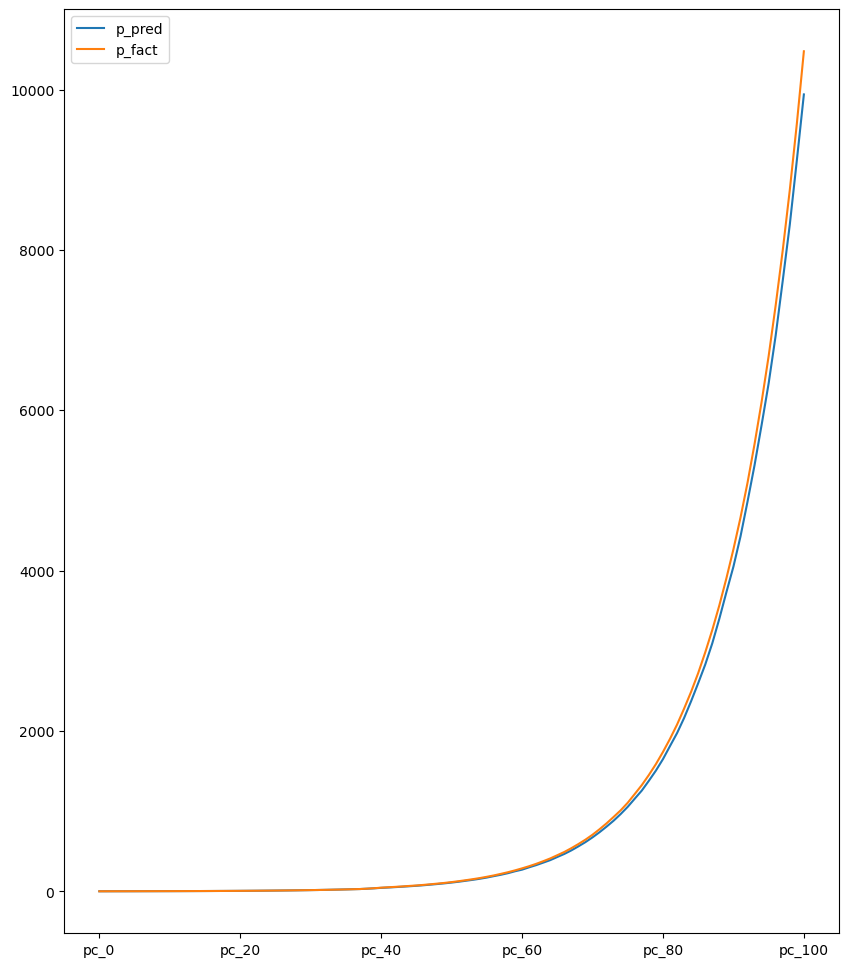

In [32]:
pd.DataFrame({'p_pred':y_pred_val[2,101:], 'p_fact': y_val.iloc[0,101:]}).plot.line(figsize=(10,12));

Volume:

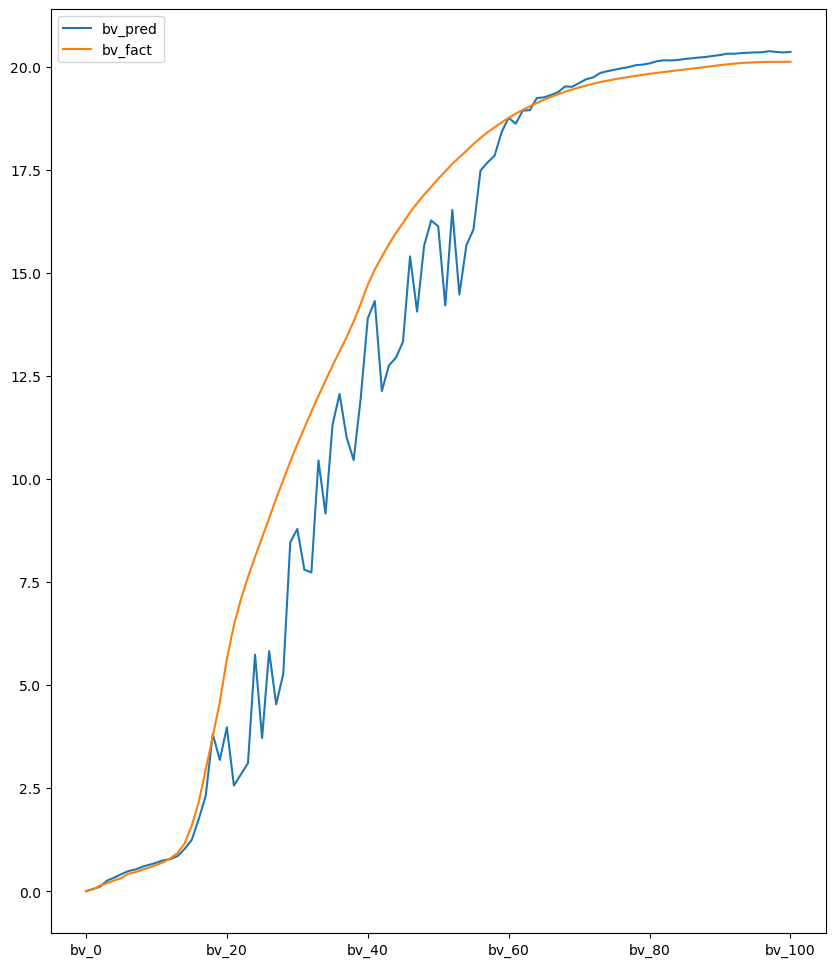

In [31]:
pd.DataFrame({'bv_pred':y_pred_val[2,:101], 'bv_fact': y_val.iloc[0,:101]}).plot.line(figsize=(10,12));

Predicted volume curve is not smooth. I believe it can be improved by using pressures as independent variables. Please see "Suggested improvements at the end".

# Prediction on the test set

In [19]:
test = pd.read_csv('test.csv'); test

,group,sample,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,permeability,ntg,thickness_effective,x,y,lithology,gr,rhob
0,6,0,2541.519832,17.574182,2.721184,2397.858599,2530.129882,2419.635540,2410.149830,2378.142534,2245.973152,2419.142862,9.686923,0.642302,8.331449,19250,4113,limestone,38.502328,2.709270
1,6,1,2492.499349,15.601646,2.731073,2493.479588,2381.180205,2374.025753,2122.706339,2535.031736,1926.894657,2213.529371,25.113567,0.202864,6.434557,19250,4113,clay sandstone,41.279069,2.629994
2,6,2,2499.758962,9.799370,2.750291,2353.105272,2557.985901,2173.083377,2302.371534,2270.180822,2546.064601,2379.507012,14.627389,0.493521,7.124782,19250,4113,clay sandstone,34.065870,2.640400
3,6,3,2484.952580,17.577824,2.644786,2577.886453,2405.878549,2541.314684,2433.153095,2541.348799,2471.677155,2431.742461,3.387930,0.734310,7.613031,19250,4113,siltstome,35.681114,2.624468
4,6,4,2520.922067,7.463433,2.677037,2367.054324,2369.093221,2143.892103,2762.000785,2747.865591,2242.994301,2369.544989,16.088282,0.753219,7.024979,19250,4113,clay sandstone,32.158592,2.670718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6,95,2506.465358,22.524565,2.717467,2226.799304,2322.424999,2321.583367,2368.146674,2351.404681,2300.565150,2436.607718,6.304332,0.617321,7.860447,19250,4113,clay sandstone,33.301977,2.623144
96,6,96,2529.205503,16.489556,2.742124,2594.698631,2360.835565,2298.041687,2182.398798,2077.087326,2272.011368,2722.061215,1.244887,0.084087,8.301461,19250,4113,clay sandstone,33.336088,2.758480
97,6,97,2495.466145,16.987957,2.729076,2198.629776,2274.317174,2385.930864,2548.291044,2397.159649,2342.184132,2214.495706,9.122389,0.385367,7.315706,19250,4113,clay sandstone,39.686841,2.617072
98,6,98,2502.966218,16.563028,2.652266,2099.259496,2187.214693,2596.884331,2181.898479,2617.709264,2391.636223,2630.869557,6.159614,0.322737,8.321823,19250,4113,clay sandstone,38.414041,2.777879


In [20]:
X_test = prep.transform(test); X_test

,onehot__lithology_clay sandstone,onehot__lithology_limestone,onehot__lithology_sandstone,onehot__lithology_shale,onehot__lithology_siltstome,scale__depth,scale__por,scale__den,scale__ct_1,scale__ct_2,...,scale__ct_5,scale__ct_6,scale__ct_7,scale__permeability,scale__ntg,scale__thickness_effective,scale__x,scale__y,scale__gr,scale__rhob
0,0.0,1.0,0.0,0.0,0.0,-0.281346,0.149370,-0.353074,0.064403,0.374027,...,-0.084024,-0.513073,0.095415,-0.227743,0.721667,1.576833,0.684469,-0.173634,0.106659,0.802766
1,1.0,0.0,0.0,0.0,0.0,-0.348986,-0.050840,-0.232226,0.352419,-0.039304,...,0.384927,-1.422837,-0.511890,0.834928,-1.338204,0.361164,0.684469,-0.173634,0.401950,0.019484
2,1.0,0.0,0.0,0.0,0.0,-0.338969,-0.639763,0.002618,-0.070397,0.451327,...,-0.406727,0.342554,-0.021654,0.112583,0.024255,0.803511,0.684469,-0.173634,-0.365132,0.122297
3,0.0,0.0,0.0,0.0,1.0,-0.359399,0.149740,-1.286665,0.606658,0.029233,...,0.403809,0.130459,0.132630,-0.661652,1.152955,1.116417,0.684469,-0.173634,-0.193360,-0.035116
4,1.0,0.0,0.0,0.0,0.0,-0.309768,-0.876858,-0.892555,-0.028382,-0.072846,...,1.021099,-0.521567,-0.051078,0.213217,1.241589,0.739550,0.684469,-0.173634,-0.567960,0.421849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.0,0.0,0.0,0.0,-0.329715,0.651828,-0.398499,-0.450838,-0.202349,...,-0.163944,-0.357420,0.147000,-0.460755,0.604568,1.274980,0.684469,-0.173634,-0.446367,-0.048201
96,1.0,0.0,0.0,0.0,0.0,-0.298338,0.039282,-0.097179,0.657297,-0.095760,...,-0.983894,-0.438833,0.990122,-0.809277,-1.894969,1.557614,0.684469,-0.173634,-0.442740,1.288980
97,1.0,0.0,0.0,0.0,0.0,-0.344892,0.089869,-0.256631,-0.535687,-0.335847,...,-0.027180,-0.238755,-0.509036,-0.266631,-0.482718,0.925869,0.684469,-0.173634,0.232626,-0.108189
98,1.0,0.0,0.0,0.0,0.0,-0.334543,0.046739,-1.195255,-0.834996,-0.577554,...,0.632054,-0.097756,0.720776,-0.470724,-0.776294,1.570664,0.684469,-0.173634,0.097271,1.480645


In [21]:
y_pred = best_estimator.predict(X_test)

In [22]:
y_pred

array([[9.96522859e-30, 3.61021483e-02, 1.29932069e-01, ...,
        4.64661775e+04, 5.22271274e+04, 5.86771898e+04],
       [9.96522859e-30, 4.43387209e-02, 1.19606932e-01, ...,
        4.64627218e+04, 5.22196721e+04, 5.86746070e+04],
       [9.96522859e-30, 6.82561752e-02, 1.24579796e-01, ...,
        4.64680091e+04, 5.22211197e+04, 5.86752981e+04],
       ...,
       [9.96522859e-30, 3.62478128e-02, 1.32281739e-01, ...,
        4.64680409e+04, 5.22284274e+04, 5.86796782e+04],
       [9.96522859e-30, 2.69101577e-02, 1.23064197e-01, ...,
        4.64657714e+04, 5.22194862e+04, 5.86790931e+04],
       [9.96522859e-30, 6.37936140e-02, 1.26354575e-01, ...,
        4.64676144e+04, 5.22243593e+04, 5.86759489e+04]])

# Suggested improvements
In my opinion, pressure values (pc_) should be used as independent variables. My understanding of the MICP experiments is that mercury injection pressures do not result from measurements, they are set by the lab before the test and mercury injection volume is measured as a function of pressure. This is confirmed by the fact that in this dataset, pressure logarithm in each experiment is increased by the same increment.

This approach will improve the accuracy of mercury injection volume prediction which is, in my understanding, the purpose of experiments: to determine injected volume as a function of pressure.


# Model summary
Model preparation pipeline (dropping unnecessary features, one-hot encoding a categorical feature and standardizing numerical features) was wrapped up in a python class. I used mean average percentage error as the metric to evaluate model performance because it measures relative error and the target variable scales differ by orders of magnitude. Several models have been tried: linear regression (as baseline), KNN regressor, random forests and boosting (AdaBoost) with each model’s hyperparameters optimized by grid search with cross-validation. AdaBoost performed best overall, although KNN achieved the best score for injected mercury volume prediction. The model performs better in pressure prediction then volume prediction which, I believe, can be remedied as proposed in "Suggested improvements" above.